In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

# from IPython.core.interactiveshell import InteractiveShell


In [2]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
# InteractiveShell.ast_node_interactivity = "all"

In [4]:
tfds.disable_progress_bar()

In [5]:
SPLIT_WEIGHTS = (8, 1, 1)
# 80%数据训练 10%的数据验证 10%的数据测试
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', 
                                                            split=list(splits), 
                                                            with_info=True, 
                                                            as_supervised=True)

/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
W0820 17:04:45.346883 4592633280 cats_vs_dogs.py:117] 1738 images were corrupted and were skipped
W0820 17:04:45.729808 4592633280 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /Users/JQC/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [8]:
raw_train

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [9]:
metadata

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=2.0.1,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    urls=['https://www.microsoft.com/en-us/download/details.aspx?id=54765'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    year

In [11]:
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

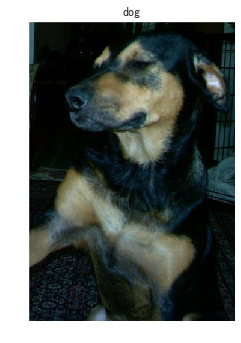

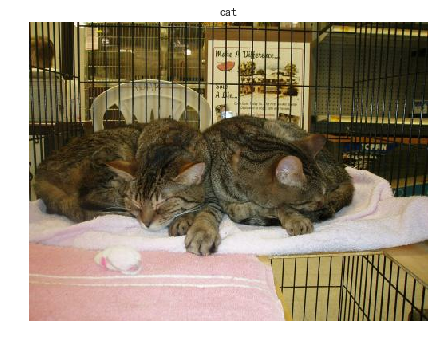

In [15]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis('off')

In [16]:
# 重新规定图片大小 并把图片缩放到[-1, 1]
IMG_SIZE = 160
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [17]:
# 映射处理数据
train = raw_train.map(format_example)
val = raw_validation.map(format_example)
test = raw_test.map(format_example)


In [19]:
# 批次大小
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [20]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                            include_top=False,
                                            weights='imagenet')

9412608/9406464 [==============================] - 58s 6us/step


In [22]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
# 冻结卷积层 这个会冻结他所有layers
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [24]:
# 将每张图片转为1280维数据
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [26]:
# 添加一层将这些特征转化为单个图片层
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shaper

TensorShape([32, 1])

In [31]:
# 建立模型
model = keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# 学习率
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 由下图可知 大约有2.25M的参数被冻结 只有1281个参数在变化
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
len(model.trainable_variables)

2

In [40]:
num_train, num_val, num_test = ( metadata.splits['train'].num_examples * weight / 10 
                                for weight in SPLIT_WEIGHTS)
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

# 模型没有训练的情况下 直接上验证数据 主要是为了以后对比
loss0,accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 18s 891ms/step - loss: 0.8494 - accuracy: 0.9016


In [36]:
round(num_train)

18610

In [42]:
# 训练模型
# history = model.fit(train_batches,
#                     epochs=initial_epochs, 
#                     validation_data=validation_batches)
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 709s 1s/step - loss: 0.6088 - accuracy: 0.9225 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 672s 1s/step - loss: 0.5570 - accuracy: 0.9288 - val_loss: 0.4610 - val_accuracy: 0.9466
Epoch 3/10
582/582 [==============================] - 679s 1s/step - loss: 0.5205 - accuracy: 0.9328 - val_loss: 0.5199 - val_accuracy: 0.9401
Epoch 4/10
582/582 [==============================] - 685s 1s/step - loss: 0.4941 - accuracy: 0.9361 - val_loss: 0.4989 - val_accuracy: 0.9440
Epoch 5/10
582/582 [==============================] - 696s 1s/step - loss: 0.4788 - accuracy: 0.9382 - val_loss: 0.4078 - val_accuracy: 0.9534
Epoch 6/10
582/582 [==============================] - 713s 1s/step - loss: 0.4585 - accuracy: 0.9404 - val_loss: 0.4108 - val_accuracy: 0.9539
Epoch 7/10
582/582 [==============================] - 679s 1s/step - loss: 0.4494 - accuracy: 0.9420 - val_loss: 0.4161 - val_accuracy

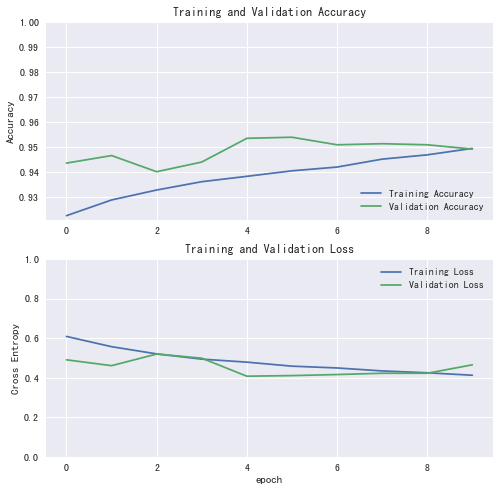

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 第二种方法 微调

In [44]:
# 把base_model解冻 但是设置底层不能训练
base_model.trainable = True

# 查看base model有多少层
print("Number of layers in the base model: ", len(base_model.layers))

# 从这一层往后开始微调
fine_tune_at = 100

# 冻结fine_tune_at之前的所有层
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [47]:
# 编译模型
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(len(model.trainable_variables))

model.summary()


58
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
     86/Unknown - 183s 2s/step - loss: 0.2929 - accuracy: 0.9622

KeyboardInterrupt: 

In [ ]:
# 绘画准确率和交叉熵损失的学习曲线 
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()